# Optimisation and Regularisation

We have now established the basics of a neural network. At its most fundamental it is a black box function,  $f: X \rightarrow Y$, that defines a mapping between two spaces  $X \subset \mathbb{R}^n$ and $Y \subset \mathbb{R}^m $. The neural network is trained by optimising an energy, or *loss* function where loss is defined by the input-output pairs of data in $X$ and $Y$. This can be encoded manually, as we did for the XOR perceptron, or constructively, as we did for the Hopfield network. We would like to have a *generic* method for optimising the neural network.

## Loss Functions

To do this we recognise that our neural network is composed of a defined set of inputs $x \in X$ and a set of parameters for each layer which we call the weights $W$ and biases $b$. The weights vector is composed of a matrix which pre-multiples the input before parsing it into an activation function, and the biases vector is an offset after the weighted input is activated. Think of them as the coefficient weights and intercepts in a non-linear regression statistical model. Now, our problem has been transformed into tweaking the weights and biases such that $L[f(x)]$ is minimised for all $x \in X$. This is nothing more than a functional optimisation problem. The first step in the function is defining $L[f(x)]$.

There are a number of common loss functions each with their own properties. The essential thing to remember is that the loss function is *generic*: provided it maintains some regularity in its formation the techniques we are going to go through will work to optimise it. The first step is defining the loss function in terms of its parameters:
$$ L = L[\{f(x; W, b) : x \in X \}]$$
This indicates that our total loss is composed of some functional combination of losses for each data point. We want to mimise the function over the entire dataset and so we aim to minimise $L_T$ by varying $W$ and $b$ against this $L$ criterion. It is possible to define the loss generically without reference to labelled data and this is referred to as *unsupervised* learning. More often, the case is that we have paired data $(x \in X, y(x) \in Y)$ so that we can compare $f(x)$ directly to $y$; this is called *supervised learning*. Some common loss functions are:

1. Mean-Squared Error: $L[f] := \sum_{x \in X} (f(x; W, b) - y(x))^2$
2. Mean-Absolute Error: $L[f] := \sum_{x \in X} |(f(x; W, b) - y(x))|$
2. Cross Entropy: $L[f] := \sum_{x \in X} -y(x) \log((f(x; W, b))$

The mean-squared error is probably the most common loss function (being prevalent across many fields of statistics, and the life sciences) and is the most understandable: it attaches the simplest positive number to the intuitive distance between two data points that has a curvature. This carries with it some useful mathematical properties and pragmatic scientific considerations. However, that is not to say that the others do not also impart useful properties into the learning problem.

Finally, we should always consider the ***data*** we are working with and choose or construct a loss function appropriate for the problem the data defines, rather than relying on some black-box packaged methods. Indeed, because there are so many excellent packages in the Deep Learning space applied research often focuses heavily on finding good loss functions that work for specific types of problems (note: architectures and graph topologies are also important features of designing a network). For some additional loss functions consider the supported examples shown in the [Flux documentation](https://fluxml.ai/Flux.jl/stable/models/losses/).

There are many techinques to deal with optimisation including, but not limited to: agent based heuristics (particle swarm, genetic algorithms), Nelder-Mead, simulated annealing, gradient descent methods, etc. Gradient descent methods work on the assumption of some regular convexity properties which neural networks are not guarenteed to have. For many years it was thought not to be best practice to use them. However, advancements in calculcating gradients efficiently as well as the development of GPUs allowed for gradient descent methods to be tested at ernormous scale and they have been found to be *extremely* effective despite the lack of convergence guarentees typically demanded by mathematicians. For this reason, they have become the *de facto* method of optimising weights and biases in neural networks and this notebook will focus on them excuslively (please try out some of the other opimisations methods if you have time to convince yourself).

##  Optimisation: Gradient Descent

To understand gradient descent we first need to understand convexity. Formally, a function is convex if a straight line between any two points in the function lies above the curve i.e. for a curve f(t) and $t_0 < t_1$ we have $g(t)>f(t) \forall t\in[t_0, t_1]$ where $g(t) = f(t_0) + (t - t_0) \cdot \left( \frac{f(t_1)-f(t_0)}{t_1-t_0} \right)$. This rather formal definition is a little bit clunky, especially for something so intuitive: convexity is simply when a curve is defined by a dip (and concave when it is defined by a hump). When there are multiple dips and humps that are restricted to some region we say that a curve is *locally convex* ( or *locally concave*). This gels well with our intuition of what convex objects are. The following curve is locally convex but not globally convex.

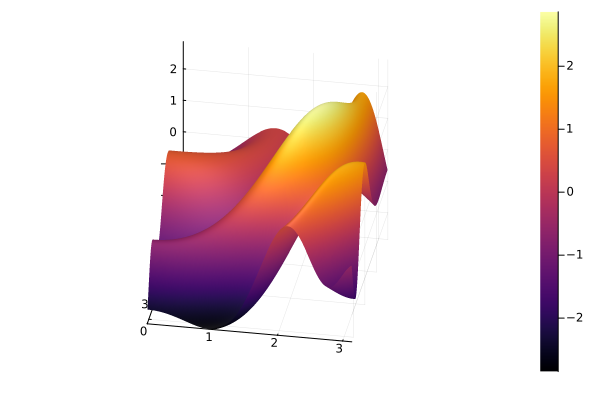

In [108]:
using Plots
f(x,y) = sin(x^2 + y^2) + sin(0.5 * x^2) - cos(0.5 * y^2)# + x^2 + y^2;
x = 0:0.01:pi # 5 pi
y = 0:0.01:pi # 5 Pi
plot(x, y, f; st=:surface, camera=(100,30))

Convexity is important because gradient descent is the method by which we find the bottom of these curves. Remembering that the bottom of a convex portion of the curve defines a local minima we can see that a method to find these points is incredibly valuable. Finding local minima (or maxima) is the primary goal of *optimisation*. You might remember from an elementary calculus class that these occur when then derivative of the function is 0; and that the second derivative test tells us if the point is a maximum (hump), or minimum (dip) and thus tells us about its curvature. This is very useful when we have a well defined gradient function which we can precisely solve the roots of: a very rare situation. Recall the definition of the derivitave of a function $f(\vec{x})$:

$$ \frac{\partial f(\vec{x})}{\partial \vec{x}} = \lim_{\vec{h}\rightarrow\vec{0}} \frac{f(\vec{x} + \vec{h}) - f(\vec{x})}{\vec{h}}$$

This definition makes it very easy to estimate the derivative of a function at a given point $\vec{x}$ by choosing an appropriately small perturbation $\vec{h}$. You may recall from Scientific Programming in Julia that it can be done with *abritrary* precision using automatic differentation. 

How does this help? The gradient of a function represents the rate of change of a function and tells us the direction of that change. For a single valued function this is given by the sign, for a vector valued function the direction of *greatest* change is given by the gradient vector often denoted $\nabla f$:

$$ \nabla f(x, y, ...) = \left(\frac{\partial f(x,y,...)}{\partial{x}}, \frac{\partial f(x,y,...)}{\partial{y}}, ...\right) $$

If we know the direction of greatest change in the function and we want to optimise it starting from a point $\vec{x}_0$ then a good strategy would be to move in that direction to maximise it, or in the oppositive direction (negative sign) to minimise it. The derivative is only valid close to, or in a *neighbourhood*, of the point $\vec{x_0}$ so the move will only be guarenteed to induce the change we want close by to where we calculate the derivative. Therefore, for an $0 <\alpha << 1$ the point:
 
$$ \vec{x}_1 = \vec{x}_0 - \alpha  \nabla f(\vec{x}_1), $$

is *guaranteed* to have the property $ f(\vec{x}_1) < f(\vec{x}_0) $. In other words, we have moved a step closer towards our goal of minimising (optimising) our function $f$. There is nothing stopping us from repeating this operation again and again getting an ever smaller value of $f$ so we define a sequence $x_t$ by:

$$ \vec{x}_t = \vec{x}_{t-1} - \alpha  \nabla f(\vec{x}_{t-1}), $$

which consequently defines the sequence $f(x_t)$ which is *monotonically decreasing*. Therefore, if the function has a local minimum somewhere near $x_0$ it has a *lower bound* and by the Montone Convergence Theorem our method is provably guarenteed to hit that bound (or get arbtrarily close) provided that we apply it enough times. If you haven't seen that theorem it is quite unecessary to understand the principle: if we know that we are above a number $A$, and we can't go below a another $B$, then by continually decreasing $A$ we will eventually hit $B$ i.e. all falling things hit the ground eventually.

While this has all been highly mathematical and quite abstract it is quite easy to code it into a function. Let's use the example function above because we can mathematically derive all of it's extrema. We will code a *numerical* differentation operator and apply it a number of times to see that it works:

In [109]:
function d(f, x; h = 0.001)
    fhx = zeros(length(x))
    fx = f(x...)
    for i in 1:length(x)
        x[i] += h;
        fhx[i] = f(x...)
        x[i] -= h
    end
    return (fhx .- fx) ./ h
end
df(x,y) = [cos(x + y) + 0.5*cos(0.5 * x), cos(x + y) + 0.5 * sin(0.5 * y)]

# true_minima = 
vi = [10.0,11.0]
count = 1
alpha = 0.0001
while sqrt(d(f, vi)[1]^2 + d(f,vi)[2]^2) > 1e-14 && count < 10^5
    count+=1
    vi .= vi - alpha * d(f, vi)
end
println("The minimum of f is $(f(vi[1], vi[2])) at (x,y) = $(vi) with the true gradient at this point being ∇f(x,y) = $(df(vi[1], vi[2]))")

The minimum of f is -1.8683508455211026 at (x,y) = [9.760104860132316, 11.114073492350133] with the true gradient at this point being ∇f(x,y) = [-0.35496803588794545, -0.7704048975177124]


We can confirm by hand that indeed a solution for the minima is $f(\vec{x}_\text{min})=-3$ with $\vec{x}_\text{min} = (7\pi/2, 4\pi) \approx (10.99, 12.56)$. So we got pretty close, but not quite there! 

## The nitty-gritty: implementation details

We now need to remove ourselves from the world of infinities and infinitesimials because we have neither infinite time to generate the sequence, nor memory to store an arbirarily small number. We must make some real *practical* choices. The most common choice to make is the step size $\alpha$ which is commonly referred to as the *learning rate*. This is known as a hyper-parameter and in all learning routines it is usually the one with the most impact. Set it too large and we will generate numerical instabilities and will not generate a solution. Set it too small and it will not move fast enough to reach the minima. Furthermore, the total step will depend on the learning rate *and* the curvature of the function at any given point.

To generate precision differentation we use *automatic differentation* routines. This allows us to not be concerned whether the gradient was computed correctly (outside of the typical numerical stability concerns of implementing a function computationally). 

Finally, we need to decide on a stopping condition. Since we typically do not know what the function extrema is we cannot code a true stopping condition. We therefore need to find a suitable proxy. The first, and most obvious, is to stop when the gradient is zero. This involves choosing a suitable bound and comparing it to the magnitude of the gradient at each step e.g. $|\nabla(f(\vec{x})| < \epsilon$. The choice of $\epsilon$ is user defined but it commonly chosen to be machine single or double precision i.e. $10^{-7}$ or $10^{-14}$. Some potential problems with this are:  

1) Incorrect choice of precision - the function might vary at much lower values than the specified $\epsilon$.

2) Periodic overshoots - a large step size will result in the particle overshooting the minimum and correcting on the next step going in circles.

3) Never reaching the minimia - a small step size might require a training routine longer than we have resources for.

The second obvious thing to is choose an upper acceptable time limit and run the routine until the time limit is reached. This has the advantage of knowing precisely the resource consumption *a priori* and compute can be appropriatley allocated. Since the gradient descent should always step in the right direction this will give close to the best possible value of the loss function for a given $\alpha$. It still requires tweaking with a given $\alpha$ and it can be very inefficient because we might arrive at an acceptable solution early in the routine and while running the whole routine will improve the solution it may not be *beneficial* to us: too many resources consumed for too little gain. In practice it is common to use both.

It is also possible to choose an acceptable *loss* and forget about finding a local minima entirely. The loss often represents some real world cost or performance target and stakeholders do not require a provably optimal solution; they require a *good-enough* solution. If we set the loss as the target we can use the descent routine to improve on exisiting solutions.

There are some provable statements one can make about the convergence rates of gradient descent. Most generally we find that for a continuous function we will converge to an error in approximately $O(1/\eta)$ steps where $\eta$ is the step size. There are some caveats here that are beyond the scope of this course but a good starting place can be found [here](https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L5.pdf).

Let's do some experiments with different learning rates.

In [191]:
startx = 2.0
starty = 1.95
rx = collect(1:0.01:4)
ry = collect(-1:0.01:4)
step=1

1

┌ Info: Saved animation to 
│   fn = /home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/slowfast.gif
└ @ Plots /home/nicholas_gale/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/slowfast.gif")
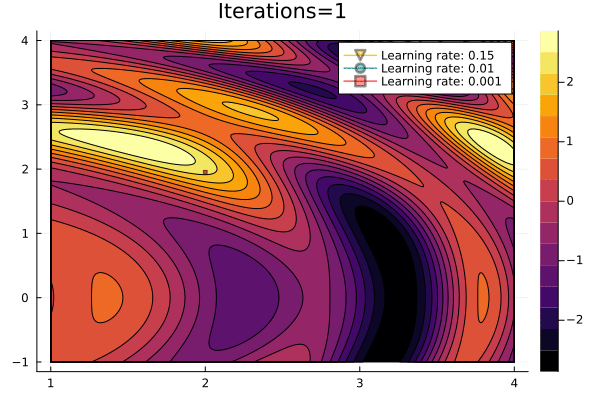

In [181]:
# Code block with an ossicilatory, slow, and just right, learning rate. 

lrs = [0.15, 0.01, 0.001]
colours = [:orange, :teal, :red]
msym = [:dtriangle, :circle, :square]
p = plot(rx, ry, f; st=:contourf)
it = 1:1000
vsx = zeros(3,length(it) + 1)
vsy = zeros(3,length(it) + 1)
vsx[:,1] .= startx
vsy[:,1] .= starty
g = zeros(2)
for t in it
    for i in 1:length(lrs)
        g = d(f, [vsx[i, t], vsy[i,t]])
        vsx[i, t+1] = vsx[i, t] .- lrs[i] .* g[1]
        vsy[i, t+1] = vsy[i, t] .- lrs[i] .* g[2]
    end
end
anim = @animate for j = 1:10:size(vsx)[end]
    plot(rx, ry, f; st=:contourf, title="Iterations=$j")
    for i in 1:length(lrs)
        plot!(vsx[i,1:j], vsy[i,1:j]; st=:path, label="Learning rate: $(lrs[i])", color=colours[i], markersize=2, markershape=msym[i], markeralpha=0.4)
    end
end
gif(anim, "./images/slowfast.gif")


Notice how when the learning rate is too high we get a numerical instability which causes some ossciliation. When it is too low we don't get even close to convergence. We need to find the sweet spot which saves our time and gives good performance. Often in Deep Learning the learning rate is the ultimate parameter (all other parameters can be left to defaults). It is certainly the parameter we should manipulate first and if we have little time it is the parameter we should focus on (as a general rule of thumb).

## Netwons Method: the *best* step size
Gradient descent is dependent on both the learning rate and the functions curvature for any given step. It is desirable therefore to have an *adaptive* step size. We would like the routine to slow down when the curvature is high so that we don't make a giant leap and skip a large amount of information (and potentially violate the conditions of the gradient descent routine generating instability). Conversely, when the landscape is flatter we would like to take a larger step and compensate for the small gradients.

Elementary calculus tells us the curvature is encoded in the *second* derivative of a function: we may recall performing the second derivative test to tell us if a function was curving up (-ve) or down (+ve) and thus determine the nature of a critical point. We might like to include this curvature information by computing the analogue of the second derivative: the Hessian. This a matrix of all of the potential combinations of second derivates. You can think of it as broadcasting the $\nabla$ operator on the derivative. The $(i,j)$th entry of the Hessian matrix $H_{ij}$ is  

$$ H_{ij}(f(\vec{x}) = \frac{\partial^2 f(\vec{x})}{\partial x_i \partial x_j}. $$

To incorporate this in our gradient descent routine we simply need to compute the inverse of the Hessian and multiply it with our gradient vector. This allows us, in some sense, to determine a step size to compensate for the curvature effects at that location: going slowly in high curvature regions and quickly in low curvature regions. There is caution that needs to be applied here; when surfaces are too flat the second derivatives might tend to zero causing numerical instability. Fortunately, there are some classes of functions where we can guarentee certain mathematical properties to achieve a super-linear convergence rate and an optimal step size by this method.

In [182]:
using LinearAlgebra
function hessian(f, x; h=0.001)
    fx = f(x...)
    d2f = zeros(length(x), length(x))
    for i = 1:length(x)
        for j = 1:length(x)
            x[i] += h; fxip = d(f, x); x[i] -= h;
            x[i] -= h; fxim = d(f, x); x[i] += h;
            d2f[i,j] = fxip[j] - fxim[j]
        end
    end
    return d2f ./ h
end

function astep(f, x, g)
    #adaptive step using the Hessian determinant
    H = hessian(f, x)
    return inv(H) * g
end

astep (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/hessian.gif
└ @ Plots /home/nicholas_gale/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/hessian.gif")
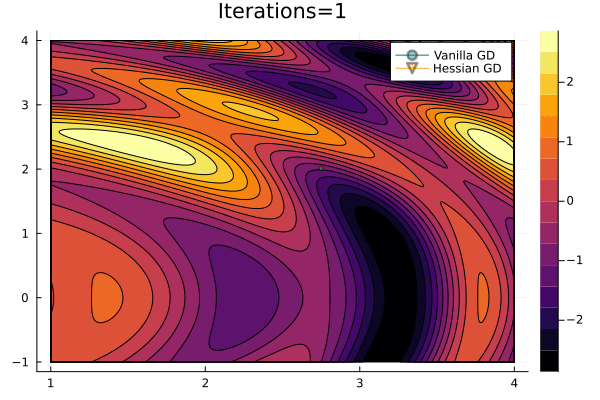

In [183]:
it = 1:150
vsx_vanilla = zeros(length(it) + 1)
vsy_vanilla = zeros(length(it) + 1)
vsx_hs = zeros(length(it) + 1)
vsy_hs = zeros(length(it) + 1)
vsx_h = zeros(length(it) + 1)
vsy_h = zeros(length(it) + 1)

vsx_vanilla[1] = 2.75
vsy_vanilla[1] = 2

vsx_hs[1] = 2.75
vsy_hs[1] = 2

vsx_h[1] = startx
vsy_h[1] = starty


eta = 0.001
g = zeros(2)
for t in it
        v_van = [vsx_vanilla[t], vsy_vanilla[t]]
        v_hes = [vsx_hs[t], vsy_hs[t]]
        v_h2 = [vsx_hs[t], vsy_hs[t]]
    
        g = d(f, v_van)
        adaptiveg = astep(f, v_hes, d(f, v_hes))
        ag2 = astep(f, v_h2, d(f, v_h2))

        vsx_vanilla[t+1] = v_van[1] .- eta .* g[1]
        vsy_vanilla[t+1] = v_van[2] .- eta .* g[2]
        
        vsx_hs[t+1] = v_hes[1] .- adaptiveg[1]
        vsy_hs[t+1] = v_hes[2] .- adaptiveg[2]
    
        vsx_h[t+1] = v_h2[1] .- ag2[1]
        vsy_h[t+1] = v_h2[2] .- ag2[2]
end

anim = @animate for t in 1:step:length(it)
    p = plot(rx, ry, f; st=:contourf, title="Iterations=$t")
    plot!(p, vsx_vanilla[1:t], vsy_vanilla[1:t]; st=:path, label="Vanilla GD", color=:teal, markersize=2, markershape=:circle, markeralpha=0.4)
    plot!(p, vsx_hs[1:t], vsy_hs[1:t]; st=:path, label="Hessian GD", color=:orange, markersize=2, markershape=:dtriangle, markeralpha=0.4)
end

gif(anim, "./images/hessian.gif")

The bane of Netwons method is the saddle point. It is a good exercise to expand out the Taylor series of the function to see where the magic in the method is coming from: it is locally solving a quadratic and then jumping to the minima of the quadratic. This makes it excellent for when surfaces are quadratic and it ensures jumps towards where the derivative is zero. Gradient descent ensures movement *downwards*. These are different things. Our example function

## Complexity: Slowing things down.

In the previous section we stated that using the Hessian matrix provides a provably optimal step size for the gradient descent routine. Presumably, this implies that gradient descent optimisation is in some sense *done*. Why can't we simply encode optimal routines in various languages and use API calls? 

The answer lies in the word *matrix*. The gradient descent routine is *linear* in the number of parameters while generating the Hessian is *quadratic*. In computational complexity theory we would denote these $O(n)$ and $O(n^2)$ respectively for $n$ parameters. What this means is that any increase in parameters will increase the time required to calculate the Hessian by that increases square. Since a parabola grows much faster than a line this increase in time is *very* noticeable when the amount of parameters is large. In deep learning we normally deal with *enormous* models and this makes computing the Hessian all but intractable. For this reason it is very rarely used.

Let's define some fairly functions and time how long it takes to compute the gradient vs the Hessian.

In [184]:
using BenchmarkTools
function bigf(x...)
    return sum(x.^2)
end

di = 1:1:20
timing_gradient = zeros(length(di))
timing_hessian = zeros(length(di))
count = 0
v = []
for i in 1:length(di)
    v = rand(di[i])
    timing_gradient[i] = @belapsed d(bigf, v)
    timing_hessian[i] = @belapsed hessian(bigf, v)
end
plot(1:length(di), [timing_gradient timing_hessian]; st=:line, label=["gradient" "hessian"])

LoadError: InterruptException:

## Momentum: Speeding things up!
To address the convergence/complexity trade of a new method of gradient descent was pioneered based on the idea of *momentum*. Essentially, the descent keeps a memory of its last update and incorporates it into the current update; much like a ball rolling down hill collects speed. This is advantageous for two reasons: it converges much quicker as the steps are larger, and it is able to escape local minima traps by skipping over them. The momentum update has an additional hyper parameter $\beta$ which dictates how much of the last update should be incorporated. The rule is:

$$ \Delta w_t = \beta \Delta w_{t-1} - \eta\nabla f(w_t) $$
$$ w_{t+1} = w_t + \Delta w_t$$

It is common to seem some variations on this rule e.g. replacing $\eta$ with $(1-\beta)$ and incorporating $\eta$ in the weight update step. In all cases $\beta$ dictates how many of the past gradients contribute to the current update step. It is frequently set to $0.9$ as a rule of thumb but it is a good parameter to experiment with (after experimenting with $\eta$).

┌ Info: Saved animation to 
│   fn = /home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/momentum.gif
└ @ Plots /home/nicholas_gale/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/momentum.gif")
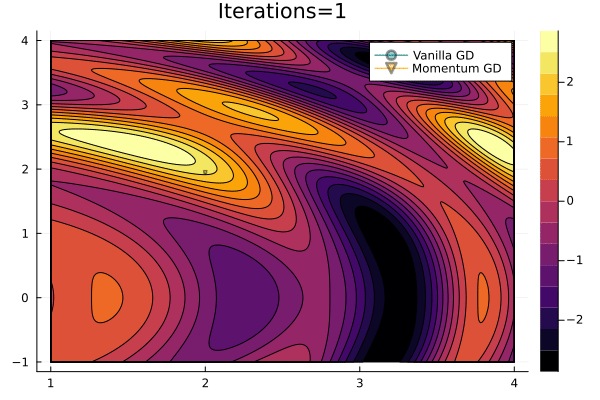

In [192]:
it = 1:150
vsx_vanilla = zeros(length(it) + 1)
vsy_vanilla = zeros(length(it) + 1)
vsx_mom = zeros(length(it) + 1)
vsy_mom = zeros(length(it) + 1)

vsx_vanilla[1] = startx
vsy_vanilla[1] = starty

vsx_mom[1] = startx
vsy_mom[1] = starty
u = zeros(2)

eta = 0.01
alpha = 0.9
g = zeros(2)
gmom = zeros(2)
for t in it
        v_van = [vsx_vanilla[t], vsy_vanilla[t]]
        v_mom = [vsx_mom[t], vsy_mom[t]]
    
        g = d(f, v_van)
        gmom = d(f, v_mom)
        u = alpha .* u .- eta .* gmom
        
        vsx_vanilla[t+1] = v_van[1] .- eta .* g[1]
        vsy_vanilla[t+1] = v_van[2] .- eta .* g[2]
        
        vsx_mom[t+1] = v_mom[1] .+ u[1]
        vsy_mom[t+1] = v_mom[2] .+ u[2]
end

anim = @animate for t in 1:step:length(it)
    p = plot(rx, ry, f; st=:contourf, title="Iterations=$t")
    plot!(p, vsx_vanilla[1:t], vsy_vanilla[1:t]; st=:path, label="Vanilla GD", color=:teal, markersize=2, markershape=:circle, markeralpha=0.4)
    plot!(p, vsx_mom[1:t], vsy_mom[1:t]; st=:path, label="Momentum GD", color=:orange, markersize=2, markershape=:dtriangle, markeralpha=0.4)
end

gif(anim, "./images/momentum.gif")

## Momentum Zoo: Really speeding things up!!
Momentum has been a common and long-standing addition to most gradient descent schemes. More recently, with the advent of extremely large datasets and fast hardware there has been an interest in developing momentum-like optimisers that offer better performance. In general they focus on adapting the step size through some function of gradients and momentums. They essentially capture some of the information that the Hessian would provide, but with linear cost, and incorporate the principles of momentum. We will go through two of these: Nesterov Momentum and ADAM. A non-exhaustive list of alternatives include:

* NADAM
* AdaGrad
* AdaMax
* RMSprop
* AMSGrad
* ...

A good place to look for the definitions and implementation details of these optimisers is in a machine learning libraries documentation e.g. [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). A good rule of thumb is to just use ADAM when you need quick training and momentum when you need well fitted training - although there are a number of caveats that go with this. Better advice is to experiment with each. They have all been designed for different tasks and datasets and you might find alternatives to be more suitable if they match your task - ADAM is particularly good with image classification. Finally, there is debate about the generalisabilty of these optimisers with some claiming that vanilla SGD (next section) is a better option for generalisation.

### Nesterov Momentum

Nesterov Momemtum descent is a fairly old improvement (some might consider it semi-classical) on the original momentum algorithm with some nice [convergence properties](https://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=dan&paperid=46009&option_lang=eng) for convex spaces. Where ordinary gradient descent converges in $O(1/t)$ momentum gradient descent converges with O(1/t^2) with $t$ being the number of time steps (and also approximately $1/\eta$. So for a sub-class of functions Nesterov desecent is provably *substantially* faster.

It is also fairly easy to understand. There are three essential steps: gradient calculation, look-forward, and momentum update. These are encapsulated by the following rules:

$$ $$

┌ Info: Saved animation to 
│   fn = /home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/nesterov_momentum.gif
└ @ Plots /home/nicholas_gale/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/nesterov_momentum.gif")
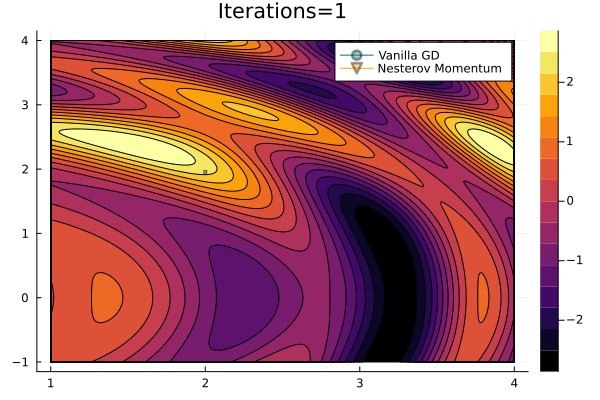

In [193]:
it = 1:150
vsx_vanilla = zeros(length(it) + 1)
vsy_vanilla = zeros(length(it) + 1)
vsx_nmom = zeros(length(it) + 1)
vsy_nmom = zeros(length(it) + 1)

vsx_vanilla[1] = startx
vsy_vanilla[1] = starty

vsx_nmom[1] = startx
vsy_nmom[1] = starty


eta = 0.01
alpha = 0.9
g = zeros(2)
un = zeros(2)
gnmom = zeros(2)
for t in it
        v_van = [vsx_vanilla[t], vsy_vanilla[t]]
        v_nmom = [vsx_nmom[t], vsy_nmom[t]]
    
        g = d(f, v_van)
        gnmom = d(f, v_nmom .+ alpha .* un)
        un = alpha .* un .- eta .* gnmom
        
        vsx_vanilla[t+1] = v_van[1] .- eta .* g[1]
        vsy_vanilla[t+1] = v_van[2] .- eta .* g[2]
        
        vsx_nmom[t+1] = v_nmom[1] .+ un[1]
        vsy_nmom[t+1] = v_nmom[2] .+ un[2]
end

anim = @animate for t in 1:step:length(it)
    p = plot(rx, ry, f; st=:contourf, title="Iterations=$t")
    plot!(p, vsx_vanilla[1:t], vsy_vanilla[1:t]; st=:path, label="Vanilla GD", color=:teal, markersize=2, markershape=:circle, markeralpha=0.4)
    plot!(p, vsx_nmom[1:t], vsy_nmom[1:t]; st=:path, label="Nesterov Momentum", color=:orange, markersize=2, markershape=:dtriangle, markeralpha=0.4)
end

gif(anim, "./images/nesterov_momentum.gif")

### ADAM
ADAM is an adapative step size momentum descent [routine](https://arxiv.org/pdf/1412.6980.pdf). It relies on tracking two auxillary variables that incorporate the gradient and the square of the gradient. It therefore has two hyperparameters to track these variables: $\beta1$ and $\beta2$. It can be implemented via the following rules:

$$ m_t = \beta_1 m_{t-1} - (1-\beta_1) \nabla f(w_t) $$
$$ v_t = \beta_2 v_{t-1} - (1 - \beta_2) \nabla f(w_t) ^2 $$
$$ \Delta w_t = \frac{\sqrt{1-\beta_2^t} m_t}{(1 - \beta_1^t) (\sqrt{v_t} + \epsilon)}$$
$$ w_{t+1} = w_{t} + \eta \Delta w_t$$.

Where $\epsilon$ is a small number (say 10^-7) for numerical stability. It is difficult to give an geometric intuition for why this might work but it can be thought of as capturing some of the curvature. An important thing to note is how the step size adapts on the first and second moments $m$ and $v$: it converges quite quickly to one in both cases. We find that ADAM often finds itself very low in the energy landscape but it doesn't deviate to much from this location in the later stages of training.

┌ Info: Saved animation to 
│   fn = /home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/ADAM.gif
└ @ Plots /home/nicholas_gale/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/ADAM.gif")
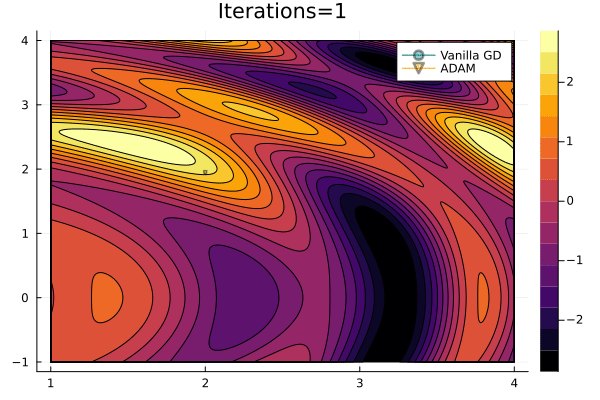

In [194]:
it = 1:150
vsx_vanilla = zeros(length(it) + 1)
vsy_vanilla = zeros(length(it) + 1)
vsx_adam = zeros(length(it) + 1)
vsy_adam = zeros(length(it) + 1)

vsx_vanilla[1] = startx
vsy_vanilla[1] = starty

vsx_adam[1] = startx
vsy_adam[1] = starty


eta = 0.01
alpha = 0.9
beta = 0.999
g = zeros(2)
uadam = zeros(2)
madam = zeros(2)
vadam = zeros(2)
for t in it
        v_van = [vsx_vanilla[t], vsy_vanilla[t]]
        v_adam = [vsx_adam[t], vsy_adam[t]]
    
        g = d(f, v_van)
        gadam = d(f, v_adam)
        madam = alpha .* madam .+ (1 - alpha) .* gadam
        vadam = beta .* vadam .+ (1 - beta) .* gadam.^2
        uadam = -eta .* madam .* sqrt(1 - beta^t) ./ (1 .- alpha^t) ./ sqrt.(vadam .+ 10^-7)
        
        vsx_vanilla[t+1] = v_van[1] .- eta .* g[1]
        vsy_vanilla[t+1] = v_van[2] .- eta .* g[2]
        
        vsx_adam[t+1] = v_adam[1] .+ uadam[1]
        vsy_adam[t+1] = v_adam[2] .+ uadam[2]
end

anim = @animate for t in 1:step:length(it)
    p = plot(rx, ry, f; st=:contourf, title="Iterations=$t")
    plot!(p, vsx_vanilla[1:t], vsy_vanilla[1:t]; st=:path, label="Vanilla GD", color=:teal, markersize=2, markershape=:circle, markeralpha=0.4)
    plot!(p, vsx_adam[1:t], vsy_adam[1:t]; st=:path, label="ADAM", color=:orange, markersize=2, markershape=:dtriangle, markeralpha=0.4)
end

gif(anim, "./images/ADAM.gif")

┌ Info: Saved animation to 
│   fn = /home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/combined_momentum.gif
└ @ Plots /home/nicholas_gale/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/nicholas_gale/Documents/University/2022 (Postdoc Stephen and David)/Course - Deep Learning/Workbooks/images/combined_momentum.gif")
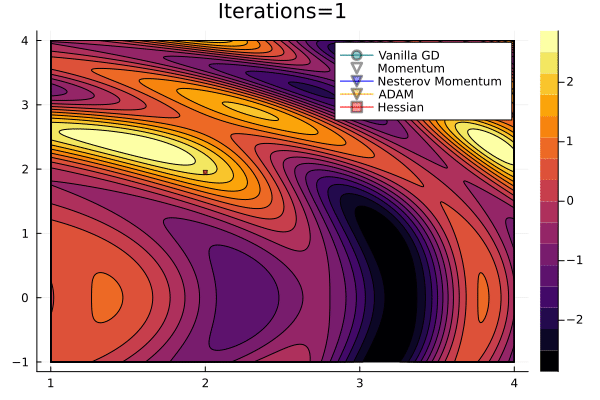

In [195]:
# Combined
anim = @animate for t in 1:step:length(it)
    p = plot(rx, ry, f; st=:contourf, title="Iterations=$t")
    plot!(p, vsx_vanilla[1:t], vsy_vanilla[1:t]; st=:path, label="Vanilla GD", color=:teal, markersize=2, markershape=:circle, markeralpha=0.4)
    plot!(p, vsx_mom[1:t], vsy_mom[1:t]; st=:path, label="Momentum", color=:white, markersize=2, markershape=:dtriangle, markeralpha=0.4)
    plot!(p, vsx_nmom[1:t], vsy_nmom[1:t]; st=:path, label="Nesterov Momentum", color=:blue, markersize=2, markershape=:dtriangle, markeralpha=0.4)
    plot!(p, vsx_adam[1:t], vsy_adam[1:t]; st=:path, label="ADAM", color=:orange, markersize=2, markershape=:dtriangle, markeralpha=0.4)
    plot!(p, vsx_h[1:t], vsy_h[1:t]; st=:path, label="Hessian", color=:red, markersize=2, markershape=:square, markeralpha=0.4)
end
gif(anim, "./images/combined_momentum.gif")

## Batching and Stochastic Gradient Descent

We now understand quite well how an arbitrary function might be solved by gradient descent optimisers. We can now turn our attention back to neural networks. Remember that each neural network is accompanied by a loss/objective function that informs us how well the model performs on each data point. Given a fixed data point $x$ we have a loss that is determined by the parameters of the network (weights and biases): $L(x; W, b)$. Now, we can say that loss *varys* in terms of these parameters and explore the parameter space until we find a local minima i.e. solve:

$$ \nabla_{(W, b)}L(x; W, b) = 0$$

This would tune our network to minimise a single loss but that might not be the optimal solution. We would like to somehow incorporate lots of data points. We consider a set of data a batch and we can define a loss on a batch of data as the mean loss of each of the individual data points. Therefore, when we apply gradient descent we move in the direction that mimimises the mean loss of the data for the batch we presented. When the batch includes the whole training dataset we refer to this as batch gradient descent.

Oftentimes we will find that the training set is too large to fit on the compute resources that we have available. We therefore have to load the data in smaller batches. When we partition the data set in a structured manner and then run through the partition sequentially we refer to the procedure as *mini-batch* descent. When we stochastically sample the partition we refer to it as *stochastic gradient descent* (SGD). When training we refer to an *epoch* of training time as $|D|/|B_s|$ iterations where $|D|$ is the size of the data set and $|B_s|$ is the batch size. In batch or mini-batch training this is the number of iterations to do a complete parse of the data, while in SGD it is the approximate number of iterations required to update on the complete data set. 

Stochastic gradient descent is by far the most common method to train our neural networks. Its advantage is two-fold: it can easily adapt batch size to available resource (think number of images that can fit on GPU memory), and the randomness allows it to avoid local minima making it a slightly better (by experimental observation) optimiser. All of the mometum based methods outlined above can be applied stochasticly.

# Regularisation

Regularisation is a broad term that is generally taken to mean: tricks and techniques to make optimisation more performant and stable (in this sense SGD is a form of regularisation, although it isn't offered referred to this way). Often the goal is to control the bias-variance trade-off or avoid overfitting. A deep learning algorithm will generally continue to improve its predicition on a training set because it has so many degrees of freedom and is broadly a universal function generator. There are two broad ways  to regularise: explicitly or implicitly.

## Explicit regularisation
Explicit regularisation is the more traditional method and follows on from the more traditional mathematical optimisation techniques and essentially involves a constrained optimisation problem. It generally involves modifying the loss function to include some penalty. Often the penalty is imposed on the function itself and in general reduces the complexity of the learned function which can be beneficial to avoid over fitting. Some common regularisations include:

1. L1: $\sum_{w\in W}\|w\|_1$ where the sum of the absolute values of the weights are added to the loss function.
2. L2: $\sum_{w\in W}\|w\|_2$ where the sum of the squares of the weights are added to the loss function.
3. L2: $\sum_{w\in W}\|w\|_\infty$ where the maximal weight is added to the loss function.
4. Entropy: $\sum_x p(x) \log(x)$ where the output is a probability distribution we penalise the entropy of the distribution.

## Implicit Regularsiation
Implicit regularisation is a little more hairy: it is more a collection of tricks which have varying degrees of explainability and rely more on experience and experimentation. We can go through a variety of common methodologies that are employed in varying capacity to varying success in a wide range of ML problems.

### Early Stopping
When training we track the loss on the training set and validation set concurrently. When the loss on the validation set begins to *increase* we stop training even though the training set still has improvement capability. This is an empirical control on the bias-variance tradeoff.

### Label Smoothing
When performing a categorisation task we often convert the output into a probability distribution over the categories. Since we train in a continuous domain we will never achieve Dirac-Delta distributions for each of the categories; we will approach them in the limit of high probability. As such, our learning task will always be able to be improved "a little" by tweaking the probabilities a little higher towards one. This can encourage overfitting. Label smoothing specifies a tolerance at which we consider a probability to be 1 or 0.

### Data Augmentation
The common wisdom in Deep Learning (although modern thinking is challenging this) is that to improve a problem we simply add more data. The more data you train on the more accurate our empirical distribution is and therefore the more accurate our fitted distribution. More data smooths things out. If we have some prior knowledge that allows us to generate data that approximates the distribution we are targeting then you can generate proxy data to train on. This is dangerous territory because we are now drifting away from the real world, but it can be very fruitful. Consider a denoiser "Super Resolution" algorithm. We might have a series of brilliant "true-to-life" photographs and a model of how a smart-phone camera might add noise to them. By downsampling and noising the photographs we can achieve an extremely large dataset which is well labelled and has the correct target for the loss function. General Adversial Networks (which are covered in a later notebook) have been extremely effective and producing useful data augmentation.

### Batch Normalisation

For a subset of the layers we normalise the input to the network to have a fixed mean and variance. This is particularly helpful when we find that our gradients are either vanishing (tending to zero) or exploding (tending to infinity). Both of these cause major problems with the stability of SGD algorithms. These issues are most prevalent in recurrent neural networks due to the feedback loops within them. Normalising the statistics of the input can be seen as fixing the expansion point of the series representation of the function and forcing the gradient expansion to be stable, while not affecting the relationship between data and classification.

### Dropout

Dropout is a very common technique and is helpful for both stabilising training *and* improving runtime performance. It has become a crowd-favourite regularisation technique for obvious reasons! It works by simply dropping or removing some of the weights for training at each update step of the gradient. Generally, it is peformed by selecting a set of nodes in the network model and "freezing" the weights asscociated with those nodes for that training step. There are a plethora of ways to perform this selection but by far the most common is to simply drop nodes with probability $p$. Some other ways include:

* Inverted Dropout
* Gaussian Dropout
* Variational Dropout


# Key Takeaways

A neural networks performance is measured by its objective or loss function. This is (usually) carefully designed to reflect some real-world performance target. The loss function can be optimised by any method but the most common is gradient descent which involves propogating losses back through the network: a technique known as *back-propagation*. Gradient descent is best used with an adapative step size but the mathematically ideal method for choosing this step is too expensive to compute. To compensate for this cost momemtum routines have been developed which have similar properties but are cheap. There is currently debate about whether these routines are better than stochastic gradient descent in a global sense. Regularisation is used to improve the stability of training a neural network.